In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import statsmodels.api as sm 

from itertools import combinations, product, permutations
from __future__ import division
from collections import Counter
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math
from networkx.readwrite import json_graph 
from geopy.geocoders import GeoNames
from geopy.geocoders import GoogleV3

import custom_funcs as cf

%matplotlib inline

In [2]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)

In [3]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [4]:
geocoder = GoogleV3(timeout=5)

In [5]:
G.nodes(data=True)[15]

('A/Canada-AB/RV1532/2009',
 {'collection_date': Timestamp('2009-01-01 00:00:00'),
  'country': 'Canada',
  'host_species': 'Human',
  'state': 'Canada-AB',
  'subtype': 'H1N1'})

In [6]:
# Get a set of 'country:host species' mappings:

country_host = set()
for n, d in G.nodes(data=True):
    country = d['country']
    host = d['host_species']
    country_host.add((country, host))
    
country_host_new = pd.DataFrame(list(country_host))


In [7]:
# Nichola has coded them as wild/domestic and avian/mammalian. I will add these into the graph. 

# Load the data
df = pd.read_csv('Country-Species_coded.csv', index_col=0)

# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

In [8]:
def get_country_location_pairs(G):
    search_terms = set()
    node_search_terms = dict()
    for n, d in G.nodes(data=True):
        country = d['country']
        specific_region = n.split('/')[-3]
        
        cleaned_country = country.replace('_', ' ')
        
        if specific_region != cleaned_country:
            search_term = '{0}_{1}'.format(cleaned_country, specific_region)
    
        else:
            search_term = cleaned_country
        
        search_terms.add(search_term)
        node_search_terms[n] = search_term.replace('_', ' ')
    return search_terms, node_search_terms

countries_to_search, node_search_terms = get_country_location_pairs(G)
countries_to_search
ecotype_map

{('-N/A-', 'Ferret'): 'Domestic',
 ('-N/A-', 'Human'): 'Human',
 ('Afghanistan', 'Chicken'): 'Domestic',
 ('Afghanistan', 'Chicken/Avian'): 'Domestic',
 ('Argentina', 'Horse'): 'Domestic',
 ('Argentina', 'Human'): 'Human',
 ('Argentina', 'Rosy-Billed Pochard'): 'Wild',
 ('Argentina', 'Rosy-Billed Pochard/Avian'): 'Wild',
 ('Australia', 'Avian'): 'Unknown',
 ('Australia', 'Black Duck'): 'Wild',
 ('Australia', 'Black Duck/Avian'): 'Wild',
 ('Australia', 'Chicken'): 'Domestic',
 ('Australia', 'Chicken/Avian'): 'Domestic',
 ('Australia', 'Duck'): 'Wild',
 ('Australia', 'Duck/Avian'): 'Wild',
 ('Australia', 'Emu'): 'Wild',
 ('Australia', 'Emu/Avian'): 'Wild',
 ('Australia', 'Human'): 'Human',
 ('Australia', 'Red-Necked Stint'): 'Wild',
 ('Australia', 'Red-Necked Stint/Avian'): 'Wild',
 ('Australia', 'Sharp-Tailed Sandpiper'): 'Wild',
 ('Australia', 'Sharp-Tailed Sandpiper/Avian'): 'Wild',
 ('Australia', 'Sooty Tern'): 'Wild',
 ('Australia', 'Sooty Tern/Avian'): 'Wild',
 ('Australia', 'Starl

In [9]:
countries_to_search

{'-N/A-_Indonesia',
 '-N/A-_St.Petersburg',
 'Afghanistan',
 'Argentina',
 'Argentina_Cordoba',
 'Australia',
 'Australia_AUS',
 'Australia_Brisbane',
 'Australia_Bunbury',
 'Australia_Cairns North',
 'Australia_Canberra',
 'Australia_Darlinghurst',
 'Australia_Melbourne',
 'Australia_New South Wales',
 'Australia_North Fitzroy',
 'Australia_Perth',
 'Australia_Queensland',
 'Australia_South Austalia',
 'Australia_South Australia',
 'Australia_Sydney',
 'Australia_Tasmania',
 'Australia_Victoria',
 'Australia_Western Australia',
 'Australia_Westmead',
 'Australia_chicken',
 'Australia_starling',
 'Austria',
 'Austria_Vienna',
 'Bangladesh',
 'Belgium',
 'Belgium_Antwerp',
 'Belgium_Brussels',
 'Belgium_Gent',
 'Belgium_Tessenderlo',
 'Bhutan',
 'Bolivia_Santa Cruz',
 'Brazil',
 'Cambodia',
 'Canada',
 'Canada_AB',
 'Canada_ALB',
 'Canada_Alberta',
 'Canada_BC',
 'Canada_British Columbia',
 'Canada_Canada-AB',
 'Canada_Canada-MB',
 'Canada_Canada-NS',
 'Canada_Canada-ON',
 'Canada_Canad

In [10]:
# Find a GPS coordinate for each
# geodata = []
# for search_term in countries_to_search:
#     new_search_term = search_term.replace('_', ' ')
#     loc = geocoder.geocode(new_search_term)
#     if loc is None:
#         loc = geocoder.geocode(new_search_term[0])
#     lat = loc.latitude
#     lon = loc.longitude
#     data = (search_term, u'{0}'.format(loc), lon, lat)
#     geodata.append(data)
#     print(data)

In [11]:
# geodf = pd.DataFrame(geodata)
# geodf.columns = ['Search Term', "Returned Location", 'Longitude', 'Latitude']
# geodf.to_csv('Country Geocoding.csv', encoding='utf-8')



In [12]:
# ecotype_map
# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'
        
        
#     cleaned_country = country.replace('_', ' ')
#     specific_region = n.split('/')[-3]
#     if specific_region != cleaned_country:
#         search_term = '{0} {1}'.format(cleaned_country, specific_region)
#     else:
#         search_term = cleaned_country
#     print(search_term)
#     location = geocoder.geocode(search_term)
#     print('  ' + str(location))
#     if location is None:
#         location = geocoder.geocode(cleaned_country)
#     lat = location.latitude
#     lon = location.longitude
    
    

    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]
#     G.node[n]['latitude'] = lat
#     G.node[n]['longitude'] = lon

In [13]:
# Identify the reassortants.

# Add reassortant status for each node.
for n, d in G.nodes(data=True):
    in_edge_types = set([d['edge_type'] for sc, sk, d in G.in_edges(n, data=True)])
    if 'reassortant' in in_edge_types:
        G.node[n]['reassortant'] = True
    elif 'full_complement' in in_edge_types:
        G.node[n]['reassortant'] = False
    else:
        G.node[n]['reassortant'] = False
        
def is_reassortant(G, node):
    return G.node[node]['reassortant']

reassortant_viruses = []
for n, d in G.nodes(data=True):
    if is_reassortant(G, n):
        reassortant_viruses.append(n)
        
print(len(reassortant_viruses))

2106


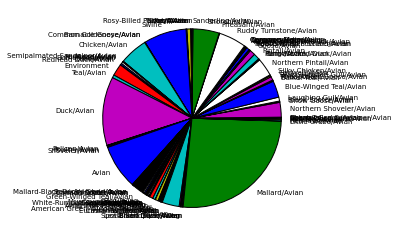

In [14]:
reassortant_hosts = []
for virus in reassortant_viruses:
    reassortant_hosts.append(G.node[virus]['host_species'])
    
plt.pie(Counter(reassortant_hosts).values(), labels=Counter(reassortant_hosts).keys())
plt.axes().set_aspect('equal')
plt.show()

In [15]:
# condensed_reassortant_hosts = []
# for host in reassortant_hosts:
#     if '/' in host:
#         host = host.split('/')[1]
#         if host == 'null':
#             host = 'Unknown'
#         condensed_reassortant_hosts.append(host)
#     else:
#         if host == 'null':
#             host = 'Unknown'
#         condensed_reassortant_hosts.append(host)

In [16]:
def get_host_group(G, node):
    host = G.node[node]['host_species']
    if 'Human' in host or 'human' in host:
        host = 'Hu'
    elif 'Avian' in host or 'avian' in host:
        host = 'Av'
    elif 'Unknown' in host or 'unknown' in host:
        host = 'Un'
    elif 'null' in host or 'Null' in host:
        host = 'Un'
    elif 'Swine' in host or 'swine' in host:
        host = 'Sw'
    else:
        host = 'Ma'
        
    return host

def correct_host_group_ecotype(G, node):
    host = get_host_group(G, node)
    
    if host == 'Av':
        if G.node[node]['ecotype'] == 'Domestic':
            host = 'Av-D'
        else:
            host = 'Av-W'
            
    return host

In [17]:
G.nodes(data=True)[0]

('A/mallard/Interior Alaska/6MP0160AR1/2006',
 {'collection_date': Timestamp('2006-08-12 00:00:00'),
  'country': 'USA',
  'ecotype': 'Wild',
  'host_species': 'Mallard/Avian',
  'reassortant': False,
  'state': 'Interior Alaska',
  'subtype': 'H3N8'})

In [18]:
# Get total representation of viruses
all_hosts = []
for n, d in G.nodes(data=True):
    all_hosts.append(correct_host_group_ecotype(G, n))
    
reassortant_hosts = []
for n, d in G.nodes(data=True):
    if d['reassortant'] == True:
        reassortant_hosts.append(correct_host_group_ecotype(G, n))

In [19]:
def counter_proportions(counter):
    total = sum(counter.values())
    
    proportions = dict()
    for key, value in counter.items():
        proportions[key] = float(value)/float(total)
        
    return proportions

def categorical_counter_xlabels(counter):
    idxs = dict()
    
    for i, key in enumerate(counter.keys()):
        idxs[key] = i
        
    return idxs

In [20]:
# all_hosts

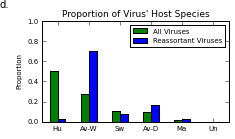

In [21]:
# Plot the proportion of hosts for reassortant viruses
counts = Counter(reassortant_hosts)
props = counter_proportions(counts)
# xpos = categorical_counter_xlabels(counts)

reassortant_proportions = pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False)
reassortant_proportions.columns = ['Reassortant Viruses']

counts = Counter(all_hosts)
props = counter_proportions(counts)
all_proportions = pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False)
all_proportions.columns = ['All Viruses']

joined_proportions = all_proportions.join(reassortant_proportions)
joined_proportions.plot(kind='bar', grid=False, figsize=golden_figsize(2), color=['green', 'blue'])

# Plotting parameters.
ax = plt.gca()
# plt.xlabel('Host Species')
ax.set_ylabel('Proportion', fontsize=7)
ax.set_title("Proportion of Virus' Host Species", fontsize=9)
plt.ylim(0, 1)
plt.legend(fontsize=7)
xlabels = ax.get_xticklabels()
plt.setp(xlabels, rotation=0, ha='center', fontsize=7) 
ylabels = ax.get_yticklabels()
plt.setp(ylabels, fontsize=7)

ax.annotate('d.', xy=(0,1), ha='left', va='top', xycoords='figure fraction')

plt.subplots_adjust(bottom=0.2, right=0.95, left=0.15)
plt.savefig('Proportion of Reassortant Viruses Host Species.pdf')

In [22]:
joined_proportions

,All Viruses,Reassortant Viruses
Hu,0.503513,0.030864
Av-W,0.274725,0.697531
Sw,0.105687,0.077398
Av-D,0.096319,0.169991
Ma,0.018195,0.023267
Un,0.001561,0.000950


In [23]:
# # Perform host species permutation test to assess what the distribution of reassortant viruses would be under null.

# host_shuffledG = G.copy()

# proportions = []

# for i in range(1000):
#     reassortant_species = dict()
#     from random import shuffle
#     hosts = [get_host_group(G, n) for n in G.nodes()]
#     shuffle(hosts)

#     # Add in condensed host
#     for i, n in enumerate(host_shuffledG.nodes()):
#         host_shuffledG.node[n]['host_group'] = hosts[i]

#     for n, d in host_shuffledG.nodes(data=True):
#         if is_reassortant(G, n):
#             if d['host_group'] not in reassortant_species.keys():
#                 reassortant_species[d['host_group']] = 1
#             else:
#                 reassortant_species[d['host_group']] += 1
                
#     proportions.append(reassortant_species)

In [24]:
# pd.DataFrame(proportions)

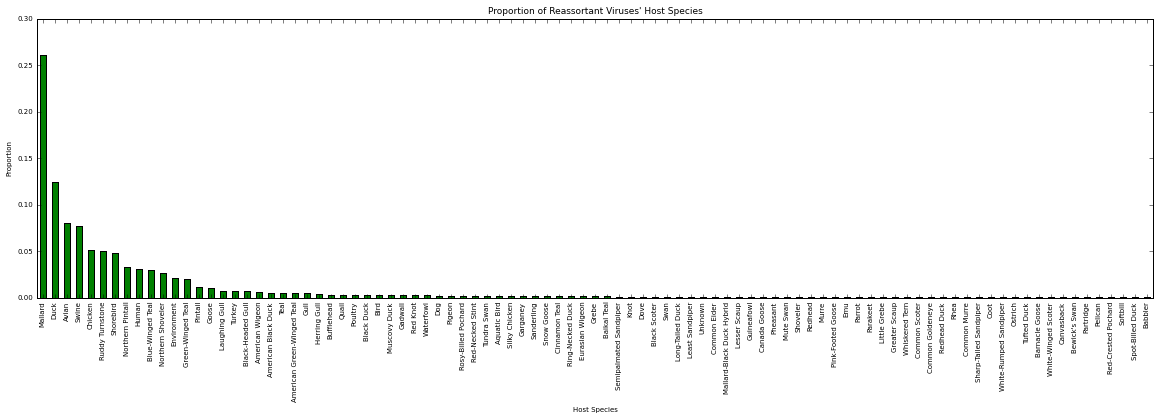

In [25]:
# Create a detailed version of the counter, which includes the exact species represented.
detailed_hosts = []
for virus in reassortant_viruses:
    host = G.node[virus]['host_species']
    if '/' in host:
        host = host.split('/')[0]
    if 'null' in host:
        host = 'Unknown'
    detailed_hosts.append(host)

counts = Counter(detailed_hosts)
props = counter_proportions(counts)
xpos = categorical_counter_xlabels(counts)

pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False).plot(kind='bar', figsize=(16,5), grid=False, legend=False, color='green')
fig = plt.gcf()
fig.set_size_inches(20,5) 
plt.xlabel('Host Species')
plt.ylabel('Proportion')
plt.title("Proportion of Reassortant Viruses' Host Species")
plt.savefig('Proportion of Reassortant Viruses Host Species (Detailed).pdf', bbox_inches='tight')

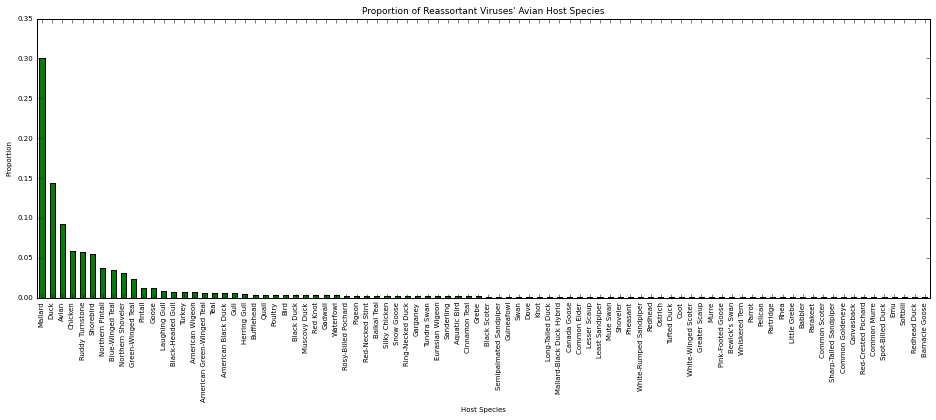

In [26]:
# Create a detailed version of the counter, which includes the exact AVIAN only species represented.
detailed_avians = []
for virus in reassortant_viruses:
    host = G.node[virus]['host_species']
    if 'Avian' in host or 'avian' in host:
        if '/' in host:
            host = host.split('/')[0]
        detailed_avians.append(host)

counts = Counter(detailed_avians)
props = counter_proportions(counts)
xpos = categorical_counter_xlabels(counts)

pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False).plot(kind='bar', figsize=(16,5), grid=False, legend=False, color='green')
fig = plt.gcf()
fig.set_size_inches(16,5) 
plt.xlabel('Host Species')
plt.ylabel('Proportion')
plt.title("Proportion of Reassortant Viruses' Avian Host Species")
plt.savefig('Proportion of Reassortant Viruses Host Species (Avian Only).pdf', bbox_inches='tight')

# Sampling Size Biases Subtype Connectivity?

Does sampling size for a particular subtype bias the subtype's connectivity with other subtypes via reassortment?

In [27]:
subtype_counts = Counter()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    subtype_counts[subtype] += 1
    
subtype_counts

Counter({'H1N1': 5607, 'H3N2': 4350, 'H5N1': 794, 'H3N8': 718, 'H4N6': 680, 'H1N2': 448, 'H9N2': 358, 'H6N2': 300, 'H10N7': 292, 'H5N2': 259, 'H7N3': 223, 'H11N9': 223, 'H6N1': 189, 'H7N2': 180, 'H2N3': 154, 'H6N6': 141, 'H6N8': 117, 'H4N8': 99, 'H3N6': 90, 'H7N9': 84, 'H7N7': 83, 'H12N5': 68, 'H4N2': 67, 'H11N2': 66, 'H8N4': 65, 'Mixed': 51, 'H7N1': 46, 'H5N8': 43, 'H5N5': 36, 'H5N3': 35, 'H2N2': 34, 'H3N1': 34, 'H1N9': 34, 'H10N1': 32, 'H6N5': 29, 'H2N9': 28, 'H10N3': 26, 'H2N1': 26, 'H1N3': 26, 'H16N3': 25, 'H10N4': 24, 'H11N1': 23, 'H7N6': 20, 'H2N7': 20, 'H4N9': 20, 'H2N5': 18, 'H10N8': 16, 'H11N3': 15, 'H10N6': 14, 'H13N6': 14, 'H10N9': 13, 'H6N3': 13, 'H7N4': 13, 'H3N3': 12, 'H4N3': 11, 'H11N8': 11, 'H10N2': 10, 'H2N8': 10, 'H1N8': 10, 'H9N5': 10, 'H13N8': 10, 'H10N5': 9, 'H3N5': 9, 'H9N1': 9, 'H9N9': 9, 'H4N1': 8, 'H3N7': 8, 'H7N8': 8, 'H5N9': 7, 'H1N7': 7, 'H6N4': 6, 'H5N7': 6, 'H3N9': 6, 'H4N5': 5, 'H6N9': 5, 'H11N6': 5, 'H12N4': 5, 'H13N9': 5, 'H11N7': 4, 'H4N7': 4, 'H12N7':

In [28]:
centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
centralities = dict(zip(centralities['Subtype'], centralities['Degree Centrality']))

In [29]:
def ols_fit_predict(xs, ys):

    est = sm.OLS(ys, xs) 
    est = est.fit()
    print(est.summary())

    # Create the best line of fit data for plotting
    x_prime = np.linspace(min(xs), max(xs), 100)[:,np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime[:,1]) 
    
    rsquared = '{0:.2f}'.format(est.rsquared)
    
    return x_prime, y_hat, rsquared

In [30]:
# Plot params
titlefs = 9 #title fontsize
axisfs = 7 #axis fontsize
figsize = (2.5, 2.5) #figure size in inches

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     22.80
Date:                Thu, 09 Jul 2015   Prob (F-statistic):           5.69e-06
Time:                        10:36:07   Log-Likelihood:                -857.71
No. Observations:                 109   AIC:                             1717.
Df Residuals:                     108   BIC:                             1720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1073.5111    224.844      4.774      0.0

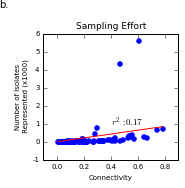

In [31]:
# Code to make scatterplot of subtype_counts vs centrality
xs = [] # centralities
ys = [] # counts in the dataset

for subtype, count in subtype_counts.items():
    xs.append(centralities[subtype])
    ys.append(count)
    
# Perform OLS regression
x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot the scatterplot and OLS
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(xs, ys, color='blue')
ax.plot(x_prime[:,1],y_hat, 'r')

ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.5, 0.3), xycoords='axes fraction', ha='left', va='center', fontsize=9)
ax.annotate(r'b.', xy=(0,1), xycoords='figure fraction', va='top')

# Plot parameters
ax.set_xlabel('Connectivity', fontsize=axisfs)
ax.set_ylabel('Number of Isolates \n Represented (x1000)', fontsize=axisfs)
ax.set_yticklabels(np.arange(-1, 7, 1))
ax.set_xticks(np.arange(0, 0.9, 0.2))
ax.set_title('Sampling Effort', fontsize=titlefs)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Subtype Representation vs. Subtype Connectivity.pdf')

# Save the data as a CSV file
csv_data = pd.DataFrame(xs, ys).reset_index()
csv_data.columns = ['Degree Centrality', 'Num Samples']
csv_data.to_csv('Subtype Representation vs. Subtype Connectivity.csv')

# Reassortment Host Range and Connectivity

One of the hypotheses I have is that that the inter-subtype degree centrality is related to the host range of the virus. To do this, I will plot a scatterplot of # of hosts represented against the degree centrality, for each subtype, with the radius of the dot proportional to the square root of the number of isolates represented.

In [32]:
subtype_hosts = dict()
subtype_counts = Counter()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    host = d['host_species']
    if host == 'mixed':
        host = 'Mixed'
    if host == 'null':
        host = 'Unknown'
    
    if subtype not in subtype_hosts.keys():
        subtype_hosts[subtype] = set()
        
    subtype_counts[subtype] += 1
    subtype_hosts[subtype].add(host)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     460.8
Date:                Thu, 09 Jul 2015   Prob (F-statistic):           9.21e-41
Time:                        10:36:07   Log-Likelihood:                -341.96
No. Observations:                 109   AIC:                             685.9
Df Residuals:                     108   BIC:                             688.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            42.5333      1.981     21.467      0.0

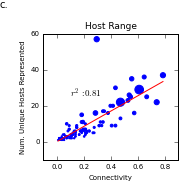

In [33]:
# Code to make bubble plot.
xs = []
ys = []
ss = []
dot_labels = []
subtypes = []

# Precisely specify the xs, ys, and sizes of the dots.
for subtype, host_set in subtype_hosts.items():
    subtypes.append(subtype)
    xs.append(centralities[subtype])
    ys.append(len(subtype_hosts[subtype]))
    ss.append(math.sqrt(subtype_counts[subtype]))
    if centralities[subtype] > 0.4 or len(subtype_hosts[subtype]) > 25:
        dot_labels.append(subtype)
    else:
        dot_labels.append('')

x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot scatterplot
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.scatter(xs, ys, s=ss, color='blue')
ax.plot(x_prime[:,1], y_hat, 'r')

# Additional plotting parameters
ax.set_xlabel('Connectivity', fontsize=axisfs)
ax.set_ylabel('Num. Unique Hosts Represented', fontsize=axisfs)
ax.set_title('Host Range', fontsize=titlefs)
ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.2, 0.5), xycoords='axes fraction', fontsize=9)
ax.annotate(r'c.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
ax.set_yticks(np.arange(0, 61, 20))
ax.set_xticks(np.arange(0, 0.9, 0.2))


plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Host Range vs. Degree Centrality.pdf')

# Finally, make a dataframe of the data to accompany the plot.
data = {'subtypes':subtypes,
        'centralities':xs,
        'num_unique_hosts':ys,
        'num_isolates':[i**2 for i in ss]}
pd.DataFrame(data).to_csv('Host Range vs. Degree Centrality.csv')

# Reassortment Geographic Range and Connectivity

Similar to the question above: Is there a relationship between the number of unique countries in which each subtype has been found?

In [34]:
subtype_countries = dict()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    country = d['country']
    
    if subtype not in subtype_countries.keys():
        subtype_countries[subtype] = set()
        
    subtype_countries[subtype].add(country)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     133.4
Date:                Thu, 09 Jul 2015   Prob (F-statistic):           1.41e-20
Time:                        10:36:08   Log-Likelihood:                -352.19
No. Observations:                 109   AIC:                             706.4
Df Residuals:                     108   BIC:                             709.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            25.1350      2.176     11.549      0.0

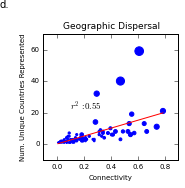

In [35]:
# Code to make bubble plot.
xs = []
ys = []
ss = []
dot_labels = []
subtypes = []

for subtype, host_set in subtype_hosts.items():
    subtypes.append(subtype)
    xs.append(centralities[subtype])
    ys.append(len(subtype_countries[subtype]))
    ss.append(math.sqrt(subtype_counts[subtype])) # Ensure that radius proportional to sqrt of counts.
    if centralities[subtype] > 0.2 and len(subtype_countries[subtype]) > 10:
        dot_labels.append(subtype)
    else:
        dot_labels.append('')

x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot the scatterplot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(xs, ys, s=ss, color='blue')
ax.plot(x_prime[:,1], y_hat, 'r')

ax.set_xlabel('Connectivity', fontsize=axisfs)
ax.set_ylabel('Num. Unique Countries Represented', fontsize=axisfs)
ax.set_title('Geographic Dispersal', fontsize=titlefs)
# ax.text(-0.05, -6, 'Size of bubble proportional to number of isolates', ha='left')
ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.2, 0.4), xycoords='axes fraction', fontsize=9)
ax.set_yticks(np.arange(0, 61, 20))
ax.set_xticks(np.arange(0, 0.9, 0.2))
ax.annotate(r'd.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Geographic Dispersal vs. Degree Centrality.pdf')

# Finally, make a dataframe of the data to accompany the plot.
data = {'subtypes':subtypes,
        'centralities':xs,
        'num_unique_countries':ys,
        'num_isolates':[i**2 for i in ss]}
pd.DataFrame(data).to_csv('Geographic Dispersal vs. Degree Centrality.csv')

# Summary

The geographic dispersal and host range both have a correlation with the degree centrality score. I interpret this as such: The geographic dispersal and host range probably have an impact on the subtype's status as a "hub" subtype. 

Using OLS regression, I have found that the sampling size is poorly correlated with the subtype degree centrality, and should not be biasing the data, while host range is the most correlated with subtype connectivity, followed by geographic dispersal. 

# Rank Correlation Test

This is a test of whether the number of nodes that were sampled for each host, country and subtype corresponds with the number of reassortant viruses found.

In [36]:
n_subtype_nodes = Counter()
n_subtype_reassortants = Counter()

n_country_nodes = Counter()
n_country_reassortants = Counter()

n_host_nodes = Counter()
n_host_reassortants = Counter()

for n, d in G.nodes(data=True):
    subtype = d['subtype']
    country = d['country']
    host = d['host_species']
    n_subtype_nodes[subtype] += 1
    n_country_nodes[country] += 1
    n_host_nodes[host] += 1

    if cf.is_reassortant(G, n):
        n_subtype_reassortants[subtype] += 1
        n_country_reassortants[country] += 1
        n_host_reassortants[host] += 1
        
       

In [37]:
# Example counter of the number of nodes
n_subtype_nodes

Counter({'H1N1': 5607, 'H3N2': 4350, 'H5N1': 794, 'H3N8': 718, 'H4N6': 680, 'H1N2': 448, 'H9N2': 358, 'H6N2': 300, 'H10N7': 292, 'H5N2': 259, 'H7N3': 223, 'H11N9': 223, 'H6N1': 189, 'H7N2': 180, 'H2N3': 154, 'H6N6': 141, 'H6N8': 117, 'H4N8': 99, 'H3N6': 90, 'H7N9': 84, 'H7N7': 83, 'H12N5': 68, 'H4N2': 67, 'H11N2': 66, 'H8N4': 65, 'Mixed': 51, 'H7N1': 46, 'H5N8': 43, 'H5N5': 36, 'H5N3': 35, 'H2N2': 34, 'H3N1': 34, 'H1N9': 34, 'H10N1': 32, 'H6N5': 29, 'H2N9': 28, 'H10N3': 26, 'H2N1': 26, 'H1N3': 26, 'H16N3': 25, 'H10N4': 24, 'H11N1': 23, 'H7N6': 20, 'H2N7': 20, 'H4N9': 20, 'H2N5': 18, 'H10N8': 16, 'H11N3': 15, 'H10N6': 14, 'H13N6': 14, 'H10N9': 13, 'H6N3': 13, 'H7N4': 13, 'H3N3': 12, 'H4N3': 11, 'H11N8': 11, 'H10N2': 10, 'H2N8': 10, 'H1N8': 10, 'H9N5': 10, 'H13N8': 10, 'H10N5': 9, 'H3N5': 9, 'H9N1': 9, 'H9N9': 9, 'H4N1': 8, 'H3N7': 8, 'H7N8': 8, 'H5N9': 7, 'H1N7': 7, 'H6N4': 6, 'H5N7': 6, 'H3N9': 6, 'H4N5': 5, 'H6N9': 5, 'H11N6': 5, 'H12N4': 5, 'H13N9': 5, 'H11N7': 4, 'H4N7': 4, 'H12N7':

In [38]:
# Example counter on the number of reassortants, by subtype
n_subtype_reassortants

Counter({'H1N1': 154, 'H3N8': 121, 'H5N2': 120, 'H6N2': 103, 'H7N3': 97, 'H1N2': 93, 'H3N2': 90, 'H4N6': 87, 'H9N2': 84, 'H6N8': 74, 'H3N6': 57, 'H6N1': 50, 'H2N3': 48, 'H4N8': 47, 'H11N9': 46, 'H10N7': 40, 'H4N2': 40, 'H5N1': 37, 'H11N2': 35, 'H12N5': 34, 'H7N7': 30, 'H5N3': 28, 'H3N1': 26, 'H7N9': 25, 'H8N4': 23, 'H2N1': 19, 'H7N2': 17, 'H2N2': 16, 'H6N5': 16, 'H1N3': 16, 'H6N6': 15, 'Mixed': 14, 'H4N9': 14, 'H10N1': 13, 'H2N9': 13, 'H7N6': 13, 'H10N8': 12, 'H10N6': 12, 'H3N3': 12, 'H1N9': 12, 'H11N3': 12, 'H5N5': 11, 'H7N1': 11, 'H10N4': 10, 'H2N8': 10, 'H16N3': 10, 'H10N5': 9, 'H2N7': 9, 'H4N3': 9, 'H10N9': 8, 'H10N2': 8, 'H3N5': 8, 'H4N1': 8, 'H10N3': 7, 'H2N5': 7, 'H3N7': 7, 'H9N5': 7, 'H11N1': 7, 'H3N9': 6, 'H5N9': 6, 'H5N8': 6, 'H7N8': 6, 'H6N3': 6, 'H9N1': 6, 'H11N8': 6, 'H1N8': 5, 'H6N9': 5, 'H13N9': 5, 'H11N7': 4, 'H4N5': 4, 'H7N4': 4, 'H6N7': 4, 'H12N7': 4, 'H1N4': 4, 'H9N7': 4, 'H9N9': 4, 'H12N8': 4, 'H12N4': 4, 'H13N6': 4, 'H5N7': 3, 'H1N6': 3, 'H13N8': 3, 'H6N4': 2, 'H9N

In [39]:
# To do rank correlation, use scipy.stats.spearmanr

from scipy.stats import spearmanr, pearsonr

# Make the data into a DataFrame
subtypes_nodes_df = pd.DataFrame(zip(n_subtype_nodes.keys(), n_subtype_nodes.values()))
subtypes_nodes_df.columns = ['subtype', 'num_nodes']
subtypes_nodes_df.set_index('subtype', inplace=True)

subtypes_reassortants_df = pd.DataFrame(zip(n_subtype_reassortants.keys(), n_subtype_reassortants.values()))
subtypes_reassortants_df.columns = ['subtype', 'num_reassortants']
subtypes_reassortants_df.set_index('subtype', inplace=True)

df = subtypes_nodes_df.join(subtypes_reassortants_df)
df

# Perform spearman correlation
spearmanr(df['num_nodes'], df['num_reassortants'])

(0.85302171234362423, 5.4131105288813776e-32)

((0.82007461613939936, 1.0781469976011957e-27), (0.95238821208249225, 5.1289418278797774e-57))
((0.6119559864582278, 4.6710496885216176e-16), (0.7858175729910476, 3.1926596465230138e-31))
((0.42755162804801961, 4.0276745916497689e-05), (0.61210080143093593, 3.8044094345520557e-10))


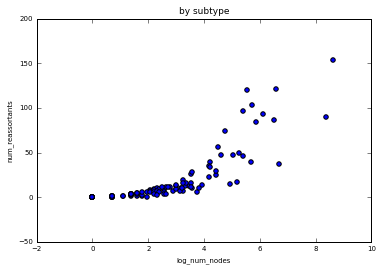

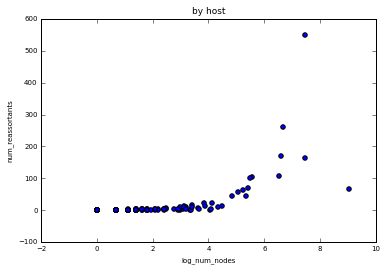

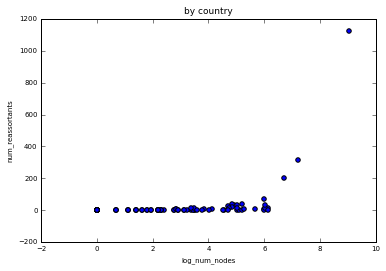

In [65]:
from random import shuffle

def make_df(counter):
    counter_df = pd.DataFrame(zip(counter.keys(), counter.values()))
    counter_df.set_index(0, inplace=True)
    return counter_df

def counts_to_dataframe(n_nodes, n_reassortants):
    nodes_df = make_df(n_nodes)
    nodes_df.columns = ['num_nodes']
    reassortants_df = make_df(n_reassortants)
    reassortants_df.columns = ['num_reassortants']
    
    joined = nodes_df.join(reassortants_df)
    joined['log_num_nodes'] = np.log(joined['num_nodes'])
    joined['log_num_reassortants'] = np.log(joined['num_reassortants'])
    return joined

def pearson_and_spearman_corr(df):
    # p_corr = df.corr(method='pearson')
    # s_corr = df.corr(method='spearman')
    
    p_corr = pearsonr(df['log_num_nodes'], df['num_reassortants'])
    s_corr = spearmanr(df['log_num_nodes'] ,df['num_reassortants'])
    
    return p_corr, s_corr

subtypes_df = counts_to_dataframe(n_subtype_nodes, n_subtype_reassortants).fillna(0)
p_corr, s_corr = pearson_and_spearman_corr(subtypes_df)
print(p_corr, s_corr)

host_df = counts_to_dataframe(n_host_nodes, n_host_reassortants).fillna(0)
p_corr, s_corr = pearson_and_spearman_corr(host_df)
print(p_corr, s_corr)

country_df = counts_to_dataframe(n_country_nodes, n_country_reassortants).fillna(0)
p_corr, s_corr = pearson_and_spearman_corr(country_df)
print(p_corr, s_corr)

subtypes_df.plot(kind='scatter', x='log_num_nodes', y='num_reassortants', title='by subtype')
host_df.plot(kind='scatter', x='log_num_nodes', y='num_reassortants', title='by host')
country_df.plot(kind='scatter', x='log_num_nodes', y='num_reassortants', title='by country')